In [2]:
%load_ext autoreload
%autoreload 2
import torch
from torch import Tensor
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
import numpy as np
import torch as t
import tqdm
#functional
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from functools import partial
from copy import deepcopy
from pympler import asizeof
import einops
import circuitsvis as cv
from src.game import Board, apply_best_moves, get_best_moves, generate_all_games, tree_walk, get_possible_moves, generate_tree
from typing import Optional, Any
from src.trie import Trie, TrieNode
from sklearn.model_selection import train_test_split
import math

/Users/omarayyub/p/Tic-Tac-Transformer/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Graphing stuff

In [16]:
def to_numpy(tensor: Tensor, flat: bool=False):
    if type(tensor)!=torch.Tensor:
        return tensor
    if flat:
        return tensor.flatten().detach().cpu().numpy()
    else:
        return tensor.detach().cpu().numpy()

def imshow(tensor: Tensor, xaxis: Optional[str]=None, yaxis: Optional[str]=None, animation_name: str='Snapshot', **kwargs: Any):
    tensor = torch.squeeze(tensor)
    px.imshow(to_numpy(tensor, flat=False),aspect='auto', 
              labels={'x':xaxis, 'y':yaxis, 'animation_name':animation_name}, 
              **kwargs).show()
# Set default colour scheme
imshow = partial(imshow, color_continuous_scale='Blues')
# Creates good defaults for showing divergent colour scales (ie with both 
# positive and negative values, where 0 is white)
imshow_div = partial(imshow, color_continuous_scale='RdBu', color_continuous_midpoint=0.0)
# Presets a bunch of defaults to imshow to make it suitable for showing heatmaps 
# of activations with x axis being input 1 and y axis being input 2.
inputs_heatmap = partial(imshow, xaxis='Input 1', yaxis='Input 2', color_continuous_scale='RdBu', color_continuous_midpoint=0.0)

def line(x, y=None, hover=None, xaxis='', yaxis='', **kwargs):
    if type(y)==torch.Tensor:
        y = to_numpy(y, flat=True)
    if type(x)==torch.Tensor:
        x = to_numpy(x, flat=True)
    fig = px.line(x, y=y, hover_name=hover, **kwargs)
    fig.update_layout(xaxis_title=xaxis, yaxis_title=yaxis)
    fig.show()
def lines(lines_list, x=None, mode='lines', labels=None, xaxis='', yaxis='', title = '', log_y=False, hover=None, **kwargs):
    if type(lines_list)==torch.Tensor:
        lines_list = [lines_list[i] for i in range(lines_list.shape[0])]
    if x is None:
        x=np.arange(len(lines_list[0]))
    fig = go.Figure(layout={'title':title})
    fig.update_xaxes(title=xaxis)
    fig.update_yaxes(title=yaxis)
    for c, line in enumerate(lines_list):
        if type(line)==torch.Tensor:
            line = to_numpy(line)
        if labels is not None:
            label = labels[c]
        else:
            label = c
        fig.add_trace(go.Scatter(x=x, y=line, mode=mode, name=label, hovertext=hover, **kwargs))
    if log_y:
        fig.update_layout(yaxis_type="log")
    fig.show()

# Training Config Stuff

In [17]:
cfg = HookedTransformerConfig(
    n_layers = 1,
    n_heads = 8,
    d_model = 128,
    d_head = 16,
    d_mlp = 512,
    act_fn = "relu",
    # normalization_type=None,
    normalization_type='LN',
    d_vocab=11,
    d_vocab_out=10,
    n_ctx=10,
    init_weights=True,
    device="cuda",
    seed = 1337,
)

lr = 1e-5
weight_decay = 1e-4
test_train_split = 0.8
epochs = 40
batch_size = 4096 * 4
total_moves = 9



In [18]:
def generate_strat_games_data():
    board = [Board()]
    print('Generating stategic games...')
    games = apply_best_moves(board)
    print('Generated ' + str(len(games)) + ' games')
    moves = np.array([[10] + game.moves_played + [9] for game in games])
    print('Generated array of moves')
    return games, moves

def generate_all_games_data():
    board = [Board()]
    print('Generating all games...')
    games = generate_all_games(board)
    print('Generated ' + str(len(games)) + ' games')
    moves = np.array([[10] + game.moves_played + ([9] * (cfg.n_ctx - len(game.moves_played))) for game in games])
    print('Generated array of moves')
    return games, moves

def gen_data_labels(moves):
    data = np.array(moves[:, :-1])
    labels = moves[:, 1:]
    print(labels.shape())
    print('Generated data and labels')
    return data, labels

def gen_data_labels_one_hot(labels):
    encoded_labels = np.array(F.one_hot(t.tensor(labels)))
    print('One hot encoded labels')
    return encoded_labels

def _train_test_split(data, encoded_labels, test_train_split=test_train_split):
    data = t.from_numpy(data)
    encoded_labels = t.from_numpy(encoded_labels).to(t.float)
    total_data = list(zip(data, encoded_labels))
    num_samples = len(total_data)
    train_size = int(test_train_split * num_samples)
    test_size = num_samples - train_size
    split_data = list(t.utils.data.random_split(total_data, [train_size, test_size]))
    train_pairs = split_data[0]
    test_pairs= split_data[1]
    train_data, train_labels = zip(*train_pairs)
    test_data, test_labels = zip(*test_pairs)

    train_data = t.stack(train_data).to(cfg.device)
    train_labels = t.stack(train_labels).to(cfg.device)
    test_data = t.stack(test_data).to(cfg.device)
    test_labels = t.stack(test_labels).to(cfg.device)

    print('Split data and labels into train and test sets')

    return train_data, train_labels, test_data, test_labels

def do_it_all(games_type):
    if games_type == 'all':
        _, moves = generate_all_games_data()
    elif games_type == 'strat':
        _, moves = generate_strat_games_data()
    data, labels = gen_data_labels(moves)
    encoded_labels = gen_data_labels_one_hot(labels)
    train_data, train_labels, test_data, test_labels = _train_test_split(data, encoded_labels)
    return train_data, train_labels, test_data, test_labels

def loss_fn(logits: Tensor, labels: Tensor):
    return t.nn.functional.cross_entropy(logits, labels)

In [19]:
train_data, train_labels, test_data, test_labels = do_it_all('all')

Generating all games...


Generated 255168 games
Generated array of moves
Generated data and labels
One hot encoded labels
Split data and labels into train and test sets


In [29]:
train_labels_all = deepcopy(train_labels)
train_data_all = deepcopy(train_data)
test_data_all = deepcopy(test_data)
test_labels_all = deepcopy(test_labels)

In [7]:
print(train_data.shape)
print(train_labels.shape)

torch.Size([204134, 9])
torch.Size([204134, 9, 10])


In [21]:
train_losses = []
test_losses = []
# ALPHATOE
model = HookedTransformer(cfg).to(cfg.device)
optimizer = t.optim.AdamW(model.parameters(), lr=lr, weight_decay=0)

# for epoch in tqdm.tqdm(range(epochs)):
for epoch in range(epochs):
    for batch in range(0, len(train_data), batch_size):
        train_logits = train_data_all[batch:batch+batch_size]
        train_labels = train_labels_all[batch:batch+batch_size]
        rearranged_train_logits = einops.rearrange(model(train_logits), "batch seq_len one_hots -> (batch seq_len) one_hots")
        rearranged_train_labels = einops.rearrange(train_labels, "batch seq_len one_hots -> (batch seq_len) one_hots")
        train_loss = loss_fn(rearranged_train_logits,rearranged_train_labels)

        train_loss.backward()

        train_losses.append(train_loss.item())
        optimizer.step()
        optimizer.zero_grad()

        with t.inference_mode():
            test_logits = model(test_data)

            rearranged_test_logits = einops.rearrange(test_logits, "batch seq_len one_hots -> (batch seq_len) one_hots")
            rearranged_test_labels = einops.rearrange(test_labels_all, "batch seq_len one_hots -> (batch seq_len) one_hots")

            test_loss = loss_fn(rearranged_test_logits, rearranged_test_labels)
            test_losses.append(test_loss.item())

    print(f"Epoch {epoch} | Train Loss: {train_loss.item()} | Test Loss: {test_loss.item()}")

Moving model to device:  cuda


Epoch 0 | Train Loss: 2.025951862335205 | Test Loss: 2.01716685295105


KeyboardInterrupt: 

In [21]:
torch.save(model, "no_ln_model.pt")

In [ ]:
model = HookedTransformer(cfg).to(cfg.device)

Moving model to device:  cuda


In [ ]:
logits = model(t.tensor([10,4,8,1,7,6,2,5,3,0]))[0, -1]
probs = t.softmax(logits, dim=-1)

print(t.argmax(logits))




tensor(9, device='cuda:0')


In [ ]:
t.save(model, 'model_no_games.pt')

In [ ]:
model_load = torch.load('./model_good_games.pt')

In [ ]:
print(t.max(model_load(t.tensor(seq_test))[0, -1]))

tensor(144.6259, device='cuda:0', grad_fn=<MaxBackward1>)


In [8]:
#lines([test_losses, train_losses])
#legend labels
lines([test_losses, train_losses], labels=['test', 'train'])

(0.0, 100.0)

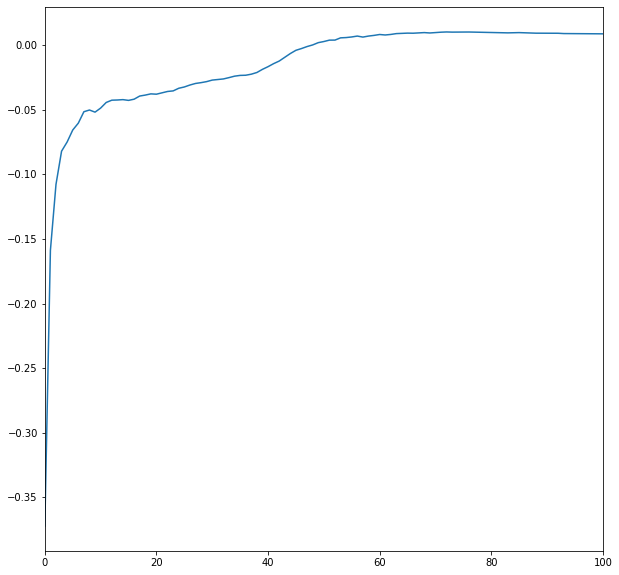

In [ ]:
#difference of lists test_losses and train_losses
diff = [test_losses[i] - train_losses[i] for i in range(len(test_losses))]
plt.figure(figsize=(10, 10))
plt.plot(diff)
#xlim
plt.xlim(0, 100)

In [ ]:
seq = t.tensor([10] * 10).to(cfg.device)
out = model(seq)

In [ ]:
out[:,-1,:]

tensor([[-68.5691, -53.3248, -33.7109,  28.4673, -47.1521,  49.8403,  20.7787,
          18.6870, -19.6562,  14.9037]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
line(test_losses, log_y=True)
# plt.plot(train_losses)

In [ ]:
line(train_losses, log_y=True)

In [ ]:
imshow(model.embed.W_E)

In [ ]:
# Take the dot product of all the embedding vectors
emb = model.embed.W_E
vec_count = emb.shape[0]
vec_dim = emb.shape[1]
print(f"The embedding shape is {emb.shape}, so our vectors of length {emb.shape[1]}")

dot_products = einops.einsum(emb, emb, "v2 embs, v1 emb -> v1 v2")

The embedding shape is torch.Size([11, 128]), so our vectors of length 128


In [ ]:
print(dot_products.shape)
imshow_div(dot_products)

torch.Size([11, 11])


## What would your hypothesis around the attention head activations be based on seeing this?
+ Jack - My poorly informed guess is that tokens with low dot products and/or low norms won't have any strong attentional interaction
+ Omar - I think that corner moves [0, 2, 6, 8] will have similar attention patterns
+ Ari - I think same as Omar, plus center attends to everything, middle edges have attention symmetry too

In [ ]:
tokens = [10,3,0,4,1,5]
# tokens = ([10] * 5) + [1,2,5,8,7]
str_tokens = [str(token) for token in tokens]
logits, cache = model.run_with_cache(torch.tensor(tokens).to('cuda'), remove_batch_dim=True)

print(type(cache))
attention_pattern = cache["pattern", 3, "attn"]
print(attention_pattern.shape)
cv.attention.attention_patterns(tokens=str_tokens, attention=attention_pattern)

<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([8, 6, 6])


In [9]:
def sample_game(model: HookedTransformer, temp: float) -> list[int]:
    assert temp > 0
    seq = [10]
    #no grad
    with t.no_grad():
        for _ in range(8):
            logits = model(t.tensor(seq))[0, -1]
            probs = t.softmax(logits / temp, dim=0)
            token = t.multinomial(probs, num_samples=1).item()
    return seq

In [10]:
ln_model = torch.load("with_ln.pt")

In [12]:
seq = [10, 0, 7, 3, 5, 6]
logits = model(t.tensor(seq))[0, -1]
probs = t.softmax(logits, dim=0)
print(probs)
token = t.multinomial(probs, num_samples=1).item()
print(token)

tensor([0.0038, 0.2533, 0.3361, 0.0118, 0.1392, 0.0060, 0.0099, 0.0040, 0.2162,
        0.0197], device='cuda:0', grad_fn=<SoftmaxBackward0>)
2


In [71]:
board.make_move(6)
board.draw_board()

| X |   |   |
| X |   | O |
| X | O |   |


In [66]:
board = Board()

In [11]:
def sample_games(model: HookedTransformer, temp: float, num_games: int) -> list[list[int]]:
    games=[]
    for _ in tqdm.tqdm(range(num_games)):
        games.append(sample_game(model, temp))
    return games


In [ ]:
model_all_games = torch.load('./model_all_games.pt')
model_good_games = torch.load('./model_good_games.pt')
model_no_games = torch.load('./model_no_games.pt')

In [ ]:
all_games_samples = sample_games(model_all_games, temp=1, num_games=1000)
good_games_samples = sample_games(model_good_games, temp=1, num_games=1000)
no_games_samples = sample_games(model_no_games, temp=1, num_games=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:28<00:00, 34.63it/s]


In [24]:
new_model_samples = sample_games(model, temp=1, num_games=1000)

100%|██████████| 1000/1000 [00:22<00:00, 44.13it/s]


In [25]:
def check_illegal_moves(game: list[int]) -> bool:
    clean_game = [token for token in game if token != 9]
    set_length = len(set(clean_game))
    return set_length == len(clean_game)

def check_illegal_moves_again(games: list[list[int]]) -> list[bool]:
    return [check_illegal_moves(game) for game in games]

In [26]:
def error_rate(games: list[list[int]]) -> float:
    return check_illegal_moves_again(games).count(False) / len(games)

In [ ]:
print(f"Error rate for new model: {error_rate(new_model_samples)}")

Error rate for new model: 0.025


In [28]:
print(new_model_samples[9])
print(new_model_samples[99])

[10, 4, 1, 2, 6, 0, 5, 8, 9]
[10, 8, 2, 3, 1, 6, 7, 4, 5]


In [ ]:
error_rate_all_games =  check_illegal_moves_again(all_games_samples).count(False)/ len(all_games_samples)
error_rate_good_games =  check_illegal_moves_again(good_games_samples).count(False)/ len(good_games_samples)
error_rate_no_games =  check_illegal_moves_again(no_games_samples).count(False)/ len(no_games_samples)

print(f"Error rate for all games: {error_rate_all_games}")
print(f"Error rate for good games: {error_rate_good_games}")
print(f"Error rate for no games: {error_rate_no_games}")


Error rate for all games: 1.0
Error rate for good games: 1.0
Error rate for no games: 0.973


In [ ]:
print(all_games_samples[9])
print(all_games_samples[99])

[10, 3, 1, 7, 6, 3, 1, 0, 3]
[10, 3, 1, 7, 3, 6, 1, 0, 3]


In [ ]:
logits = model_all_games(t.tensor([10, 3, 1]))[0, -1]
t.argmax(logits)
probs = t.softmax(logits, dim=0)

print(probs)

tensor([9.8593e-15, 6.2340e-11, 0.0000e+00, 9.1016e-09, 0.0000e+00, 5.3438e-36,
        1.0420e-11, 1.0000e+00, 1.5051e-34, 7.2200e-39], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [ ]:
board = Board()

tree_entropy, games_seen = tree_walk(board, get_best_moves)
print(tree_entropy)
print(games_seen)
print(tree_entropy/games_seen)

1090.491104007059
12134
0.08987070248945599


In [ ]:
board = Board()

tree_entropy, games_seen = tree_walk(board, get_possible_moves)
print(tree_entropy)
print(games_seen)
print(tree_entropy/games_seen)

212007.99713631268
740170
0.2864314915982986


In [ ]:
board = Board()
generate_tree(board, get_best_moves)

In [3]:
trie = Trie()
boards = [Board()]
games = generate_all_games(boards)

moves = [[10] + game.moves_played + ([9] * (10 - len(game.moves_played))) for game in games]


#split moves into train and test randomly
train_moves, _ = train_test_split(moves, test_size=0.2, random_state=42)

for move in train_moves:
    trie.insert(move)

In [ ]:
moves[0]

[10, 0, 1, 3, 2, 6, 9, 9, 9, 9]

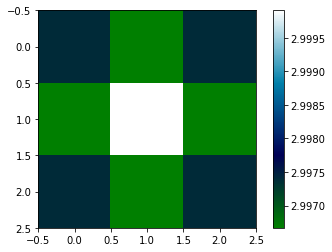

In [ ]:
#torch tensor 3 by 3
first_move_entropy = t.tensor([[trie.partial_game_entropy([10, 0]), trie.partial_game_entropy([10, 1]), trie.partial_game_entropy([10, 2])], 
                               [trie.partial_game_entropy([10, 3]), trie.partial_game_entropy([10, 4]), trie.partial_game_entropy([10, 5])],
                               [trie.partial_game_entropy([10, 6]), trie.partial_game_entropy([10, 7]), trie.partial_game_entropy([10, 8])]])

#imshow tensor
plt.imshow(first_move_entropy, cmap='ocean', interpolation='nearest');
plt.colorbar();


#### Tic Tac Toe Entropy
Calculated entropy for each first move on the board corresponding to a sequence of [10, n] where n is any position on the board. Symmetry of entropy can be seen in the image show plot above. Minor variations in entropy symmetry is due to the test train split. Below the training games for the transformer model are represented as a Trie data structure and average entropy is calculated over all tokens in the training set. This entropy represents the lower bound of cross entropy loss for the model. 

In [4]:
print(f'Total Entropy: {trie.total_entropy()}')
print(f'Game Count: {trie.root.game_count}')
print(f'Total Tokens: {trie.root.game_count * 10}')
print(f'Average Entropy: {trie.average_entropy()}')

Total Entropy: 2495850.8669433054
Game Count: 204134
Total Tokens: 2041340
Average Entropy: 1.2226531919931543
